In [46]:
import pandas as pd
from pyntcloud import PyntCloud
import numpy as np
from scipy.spatial.transform import Rotation as R
import pycolmap
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
pt = PyntCloud.from_file('../data/birmingham_blocks/segmented-cloud-subsampled.ply')

In [48]:
help(pt)

Help on PyntCloud in module pyntcloud.core_class object:

class PyntCloud(builtins.object)
 |  PyntCloud(points, mesh=None, structures=None, **kwargs)
 |  
 |  A Pythonic Point Cloud.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, points, mesh=None, structures=None, **kwargs)
 |      Create PyntCloud.
 |      
 |      Parameters
 |      ----------
 |      points: pd.DataFrame
 |          DataFrame of N rows by M columns.
 |          Each row represents one point of the point cloud.
 |          Each column represents one scalar field associated to its corresponding point.
 |      
 |      mesh: pd.DataFrame or None, optional
 |          Default: None
 |          Triangular mesh associated with points.
 |      
 |      structures: dict, optional
 |          Map key(base.Structure.id) to val(base.Structure)
 |      
 |      kwargs: custom attributes
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  add_scalar_field(self, name, **kwargs)
 |      Add one or multiple column

In [49]:
pt.points

,x,y,z,red,green,blue,scalar_R,scalar_G,scalar_B,scalar_Composite,scalar_Original_cloud_index,scalar_R_#1,scalar_G_#1,scalar_B_#1,scalar_Composite_#1,scalar_Classification
0,340.81250,365.43750,14.099998,103,109,112,103.0,109.0,112.0,108.000000,0.0,103.0,109.0,112.0,108.000000,6.0
1,340.37500,365.43750,14.160004,97,101,105,97.0,101.0,105.0,101.000000,0.0,97.0,101.0,105.0,101.000000,6.0
2,338.06250,365.21875,14.040001,105,112,121,105.0,112.0,121.0,112.666664,0.0,105.0,112.0,121.0,112.666664,6.0
3,341.28125,365.21875,14.020004,96,100,103,96.0,100.0,103.0,99.666664,0.0,96.0,100.0,103.0,99.666664,6.0
4,341.75000,364.96875,14.000000,84,89,91,84.0,89.0,91.0,88.000000,0.0,84.0,89.0,91.0,88.000000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107825,368.84375,228.31250,17.080002,51,52,51,51.0,52.0,51.0,51.333332,5.0,NaN,NaN,NaN,NaN,1.0
107826,369.18750,227.34375,17.980003,53,64,60,53.0,64.0,60.0,59.000000,5.0,NaN,NaN,NaN,NaN,1.0
107827,369.43750,226.21875,18.870003,91,120,52,91.0,120.0,52.0,87.666664,5.0,NaN,NaN,NaN,NaN,1.0
107828,370.46875,226.90625,14.470001,73,80,53,73.0,80.0,53.0,68.666664,5.0,NaN,NaN,NaN,NaN,1.0


In [50]:
pt.points['label'] = np.astype(pt.points['scalar_Classification'].values, int)

In [51]:
classes_count = pd.DataFrame(pt.points['label']).value_counts().reset_index().set_index('label')

In [52]:
classes_df = pd.DataFrame.from_dict({'label': [1, 2, 3, 4, 5, 6], 'name': ['building', 'green area', 'car', 'ground', 'tree', 'road']}).set_index('label')
classes_df

,name
label,
1,building
2,green area
3,car
4,ground
5,tree
6,road


In [53]:
counts = classes_df.join(classes_count)

In [54]:
counts

,name,count
label,,
1,building,48361
2,green area,9617
3,car,1883
4,ground,24441
5,tree,8417
6,road,15111


In [55]:
scale_exp = np.column_stack((pt.points['scale_0'], pt.points['scale_1'], pt.points['scale_2']))
scale_exp.shape

KeyError: 'scale_0'

In [6]:
rot_quart = np.column_stack((pt.points['rot_0'], pt.points['rot_1'], pt.points['rot_2'], pt.points['rot_3']))
rot_quart

array([[ 0.9754956 , -0.1902563 , -0.07379083, -0.08225437],
       [ 0.94450295,  0.17096156, -0.12695722, -0.2501364 ],
       [ 0.8990232 , -0.14114122,  0.4138816 ,  0.02320598],
       ...,
       [ 0.82073337,  0.25088063,  0.24404198,  0.45155194],
       [ 0.9485955 ,  0.31183812,  0.02252635, -0.04915417],
       [ 0.98090684, -0.10276549, -0.16236897, -0.0299554 ]],
      dtype=float32)

In [7]:
R.from_quat(rot_quart[0]).as_matrix()

array([[ 0.9167149 , -0.38332761, -0.11266644],
       [-0.35904913, -0.91407351,  0.1885559 ],
       [-0.1752641 , -0.13239922, -0.97557826]])

In [8]:
scal = np.exp(scale_exp[0, np.newaxis]) * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rot = R.from_quat(rot_quart[0]).as_matrix()

In [9]:
np.exp(scale_exp[0])

array([0.00171603, 0.02640267, 0.00164669], dtype=float32)

In [10]:
scal

array([[0.00171603, 0.        , 0.        ],
       [0.        , 0.02640267, 0.        ],
       [0.        , 0.        , 0.00164669]])

In [11]:
cov = rot @ scal @ scal.T @ rot.T

In [12]:
cov

array([[1.04941167e-04, 2.43230141e-04, 3.52043873e-05],
       [2.43230141e-04, 5.82925209e-04, 8.40515151e-05],
       [3.52043873e-05, 8.40515151e-05, 1.48910791e-05]])

(array([21840., 19576., 22871., 21750., 28319., 28561., 37467., 26116.,
        30182., 36764.]),
 array([-9.99994934e-01, -7.99996018e-01, -5.99997163e-01, -3.99998248e-01,
        -1.99999392e-01, -5.36441803e-07,  1.99998438e-01,  3.99997294e-01,
         5.99996150e-01,  7.99995005e-01,  9.99993861e-01]),
 <BarContainer object of 10 artists>)

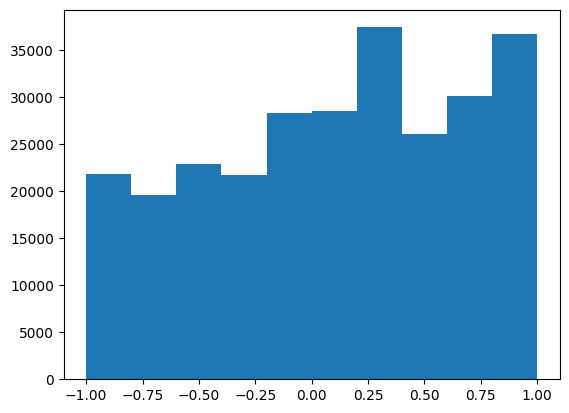

In [13]:
ids = (-1 < pt.points['x']) & (pt.points['x'] < 1) & (pt.points['y'] > -1) & (pt.points['y'] < 1)
plt.hist(pt.points['x'][ids])

In [14]:
np.sum(ids) / ids.shape[0]

np.float64(0.22853040556069537)

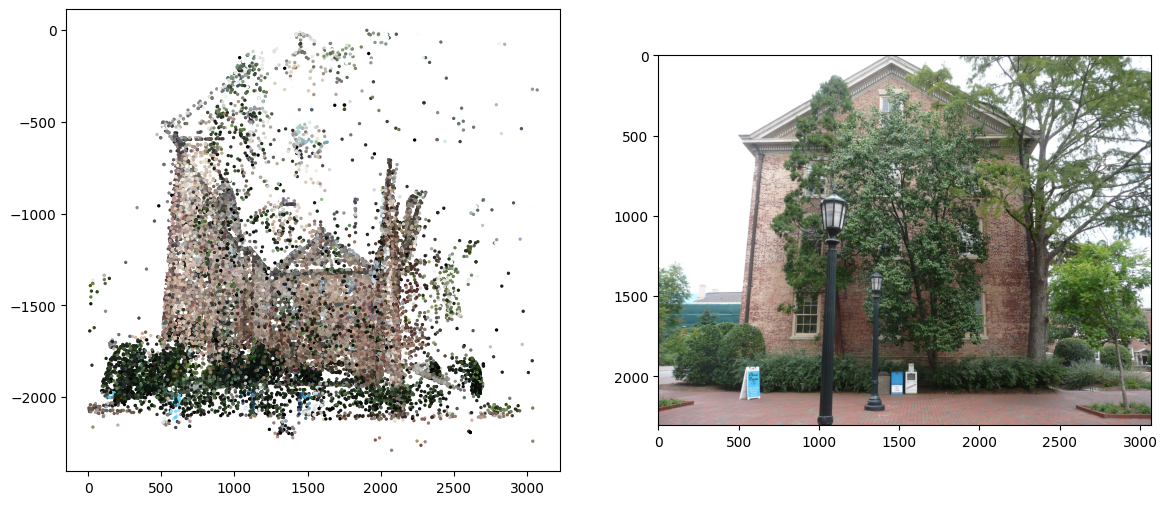

In [15]:
from matplotlib import image as mpimg
from pathlib import Path
from src.geometry.point_transformation import *

scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'
output_path = scene_folder / 'undistorted_images'

reconstruction = pycolmap.Reconstruction(output_path / 'sparse')

img_id = 10
img = reconstruction.images[img_id]
cam_id = 1

extrinsic_matrix = get_extrinsic_params(img.cam_from_world)
f, cx, cy = reconstruction.cameras[cam_id].params
width, height = reconstruction.cameras[cam_id].width, reconstruction.cameras[cam_id].height
znear, zfar = 1, 10
intrinsic_matrix = get_intrinsic_opengl_params(f, f, height, width, zfar=zfar, znear=znear)

colors = np.array([p.color for p in reconstruction.points3D.values()]) / 255.0
homogeneous_points = convert_to_homogenous(get_points_xyz(reconstruction))
camera_coordinates = homogeneous_points @ extrinsic_matrix.T
clip_coordinates = camera_coordinates @ intrinsic_matrix.T
point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)

ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
c = colors[point_ids]

screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
image = mpimg.imread(images_folder / f'{img.name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(screen_coordinates[:, 0], -screen_coordinates[:, 1], s=2, c=c)
plt.subplot(1, 2, 2)
plt.imshow(image)

In [16]:
print(reconstruction.points3D)
print(pt.points.shape)

MapPoint3DIdToPoint3D(num_points3D=57713)
(1196541, 62)


In [17]:
xyz = np.column_stack((pt.points['x'][ids], pt.points['y'][ids], pt.points['z'][ids]))

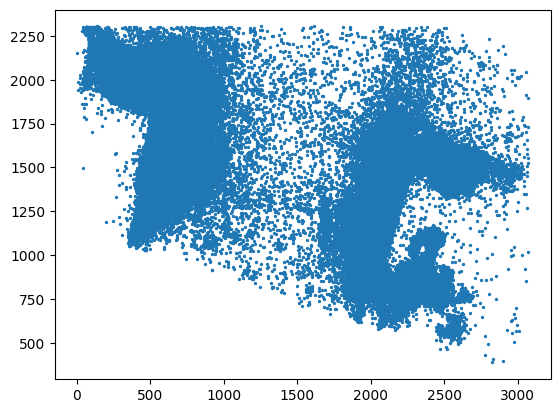

In [18]:
homogeneous_points = convert_to_homogenous(xyz)
camera_coordinates = homogeneous_points @ extrinsic_matrix.T
clip_coordinates = camera_coordinates @ intrinsic_matrix.T
point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)

ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
plt.scatter(screen_coordinates[:, 0], screen_coordinates[:, 1], s=2)

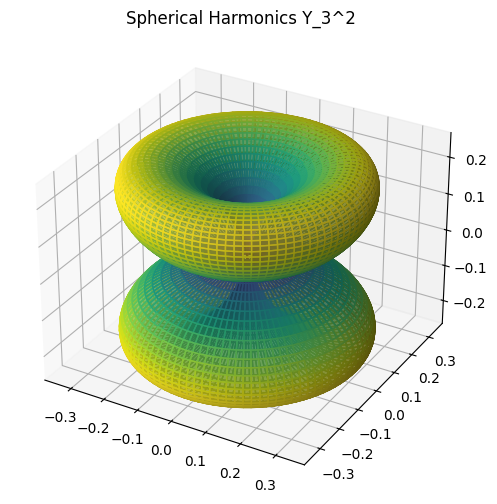

In [19]:
import numpy as np
from scipy.special import sph_harm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the degree (l) and order (m)
l = 3
m = 2

# Create a grid of theta (polar) and phi (azimuthal) angles
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

# Compute the spherical harmonics
Y_lm = sph_harm(m, l, phi, theta)

# To plot spherical harmonics, we need to map the spherical coordinates to Cartesian
# Cartesian coordinates (for visualization)
x = np.abs(Y_lm) * np.sin(theta) * np.cos(phi)
y = np.abs(Y_lm) * np.sin(theta) * np.sin(phi)
z = np.abs(Y_lm) * np.cos(theta)

# 3D plot of the spherical harmonics
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.viridis(np.abs(Y_lm / Y_lm.max())), alpha=0.6)
ax.set_title(f"Spherical Harmonics Y_{l}^{m}")
plt.show()


In [20]:
Y_lm

array([[ 0.        +0.00000000e+00j,  0.00102828+0.00000000e+00j,
         0.00410276+0.00000000e+00j, ..., -0.00410276+0.00000000e+00j,
        -0.00102828+0.00000000e+00j, -0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.00102   +1.30171950e-04j,
         0.00406975+5.19377870e-04j, ..., -0.00406975-5.19377870e-04j,
        -0.00102   -1.30171950e-04j, -0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.00099532+2.58249385e-04j,
         0.00397126+1.03039876e-03j, ..., -0.00397126-1.03039876e-03j,
        -0.00099532-2.58249385e-04j, -0.        +0.00000000e+00j],
       ...,
       [ 0.        +0.00000000e+00j,  0.00099532-2.58249385e-04j,
         0.00397126-1.03039876e-03j, ..., -0.00397126+1.03039876e-03j,
        -0.00099532+2.58249385e-04j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.00102   -1.30171950e-04j,
         0.00406975-5.19377870e-04j, ..., -0.00406975+5.19377870e-04j,
        -0.00102   +1.30171950e-04j